In [1]:
pip install srtm.py


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.9/99.9 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for srtm.py: filename=SRTM.py-0.3.7-py3-none-any.whl size=105846 sha256=41d71a9ccae2c7ac85fea5e979dfd1fe6eb1fa73b6dc8e632fca393ebd1a2d77
  Stored in directory: /root/.cache/pip/wheels/86/8d/be/cafef7d5285bb6b4a7a42ba3fc72b6c9edccb0d02679acb8ea
Successfully built srtm.py
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 2.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 42.4 MB/s eta 0:00:0000:01
  Attempting uninstall: shapely
    Found existing installation: Shapely 1.8.5.post1
    Uninstalling Shapely-1.8.5.post1:
      Successfully uninstalled Shapely-1.8.5.post1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 56.0 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
import matplotlib.pyplot as plt


/opt/conda/lib/python3.10/site-packages/osmnx/_overpass.py:254: UserWarning: This area is 70 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)


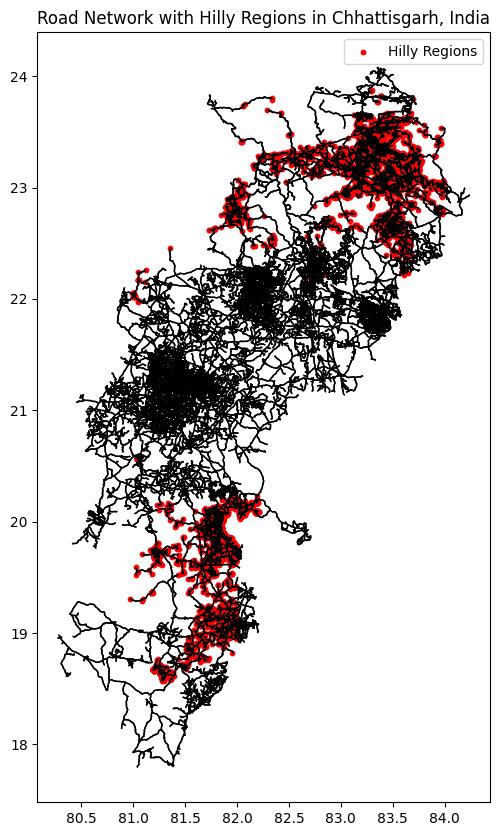

In [5]:
import geopandas as gpd
import numpy as np
import osmnx as ox
import rasterio
from rasterio.merge import merge
from rasterio.plot import show
import glob
from shapely.geometry import Point

# Define the location
place_name = "Chhattisgarh, India"

# Download road network data for Chhattisgarh
G = ox.graph_from_place(place_name, network_type='all')

# Convert the graph to a GeoDataFrame
nodes, edges = ox.graph_to_gdfs(G)

# Load multiple DEM tiles (assume you have downloaded multiple tif files for Chhattisgarh)
dem_files = glob.glob('/kaggle/input/roadterrain/*.tif')  # Replace with the path where your DEM files are located

# Open all DEM files and merge them into a single dataset
dem_list = []
for dem_file in dem_files:
    src = rasterio.open(dem_file)
    dem_list.append(src)

# Merge DEM files into one (mosaic)
mosaic, out_trans = merge(dem_list)

# Use the first DEM file's metadata and update it to match the mosaic
out_meta = src.meta.copy()
out_meta.update({
    "driver": "GTiff",
    "height": mosaic.shape[1],
    "width": mosaic.shape[2],
    "transform": out_trans
})

# You can write the merged DEM to a new file if needed
with rasterio.open("merged_chhattisgarh_dem.tif", "w", **out_meta) as dest:
    dest.write(mosaic)

# Use the mosaic directly for elevation extraction
def get_elevation(lat, lon):
    # Convert coordinates to row and column in the mosaic DEM
    row, col = rasterio.transform.rowcol(out_trans, lon, lat)
    # Cast to integers to use as indices
    row, col = int(row), int(col)
    
    # Ensure row and col are within the mosaic's bounds
    if 0 <= row < mosaic.shape[1] and 0 <= col < mosaic.shape[2]:
        return mosaic[0, row, col]
    else:
        return np.nan  # Return NaN for out-of-bounds coordinates

# Add elevation data to nodes
nodes['elevation'] = nodes.apply(lambda row: get_elevation(row['y'], row['x']), axis=1)

# Classify nodes into hilly and non-hilly based on a threshold elevation (e.g., 500 meters)
nodes['hilly'] = nodes['elevation'] > 500  # Adjust threshold as necessary

# Plot road network with hilly and non-hilly regions
fig, ax = plt.subplots(figsize=(10, 10))
edges.plot(ax=ax, linewidth=1, edgecolor='black')
nodes[nodes['hilly']].plot(ax=ax, color='red', markersize=10, label='Hilly Regions')
plt.title(f"Road Network with Hilly Regions in {place_name}")
plt.legend()
plt.show()

# Close the DEM files after merging
for src in dem_list:
    src.close()


In [21]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [24]:
import numpy as np

# Assuming mosaic is already a numpy array
# Calculate the gradient (which gives slope in x and y directions)
dy, dx = np.gradient(mosaic[0])  # mosaic[0] assumes the first band contains elevation data

# Calculate slope in degrees
slope = np.arctan(np.sqrt(dx**2 + dy**2)) * (180 / np.pi)

# Add slope to the nodes
def get_slope(lat, lon):
    # Convert coordinates to row and column in the mosaic DEM
    row, col = rasterio.transform.rowcol(out_trans, lon, lat)
    row, col = int(row), int(col)
    
    # Ensure row and col are within bounds
    if 0 <= row < slope.shape[0] and 0 <= col < slope.shape[1]:
        return slope[row, col]
    else:
        return np.nan  # Return NaN if out of bounds

# Update nodes with slope data
nodes['slope'] = nodes.apply(lambda row: get_slope(row['y'], row['x']), axis=1)

# Classify steep areas based on slope thresholds (e.g., >15 degrees is steep)
nodes['steep'] = nodes['slope'] > 15


In [25]:
# Check the output of slope and steep classification
print(nodes[['elevation', 'slope', 'steep']].head())


            elevation      slope  steep
osmid                                  
2130346973       96.0  60.982859   True
3332807280      191.0  56.309932   True
5209874003      164.0  57.688467   True
8131848270        NaN        NaN  False
9966186781        NaN        NaN  False


In [37]:
# Calculate degree centrality for each node
nodes['degree_centrality'] = nodes.apply(lambda node: len(G[node.name]), axis=1)


In [38]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd

# Load the CSV files
edges_file_path = '/kaggle/input/nodes-and-edges/chhattisgarh_roads_edges.csv'
nodes_file_path = '/content/chhattisgarh_roads_nodes.csv'

# Load the CSV files with error handling
edges_df = pd.read_csv(edges_file_path, on_bad_lines='skip', quoting=3)
nodes_df = pd.read_csv(nodes_file_path)

# Inspect the first few rows of each dataset
print("Roads Edges Data:")
print(edges_df.head(), "\n")

print("Roads Nodes Data:")
print(nodes_df.head())

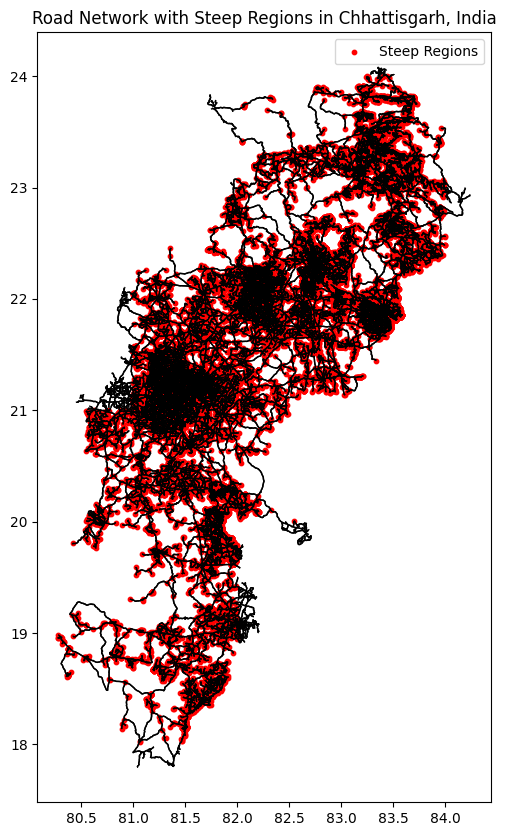

In [26]:
import matplotlib.pyplot as plt

# Plot road network with steep regions
fig, ax = plt.subplots(figsize=(10, 10))
edges.plot(ax=ax, linewidth=1, edgecolor='black')
nodes[nodes['steep']].plot(ax=ax, color='red', markersize=10, label='Steep Regions')
plt.title(f"Road Network with Steep Regions in {place_name}")
plt.legend()
plt.show()


In [27]:
print(nodes['slope'].isna().sum())  # Check how many nodes have NaN for slope


433


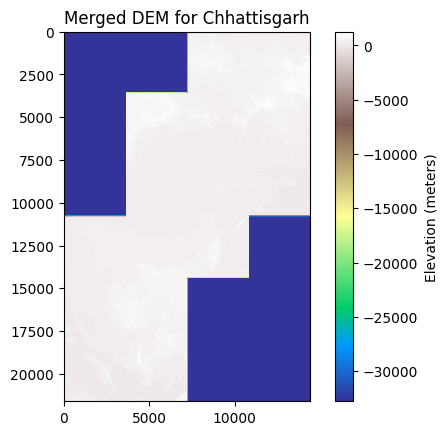

In [28]:
plt.imshow(mosaic[0], cmap='terrain')  # Visualize the DEM data (first band)
plt.colorbar(label='Elevation (meters)')
plt.title('Merged DEM for Chhattisgarh')
plt.show()


In [7]:
pip install geopandas osmnx folium shapely rasterio matplotlib

Note: you may need to restart the kernel to use updated packages.


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import osmnx as ox
import folium
import rasterio

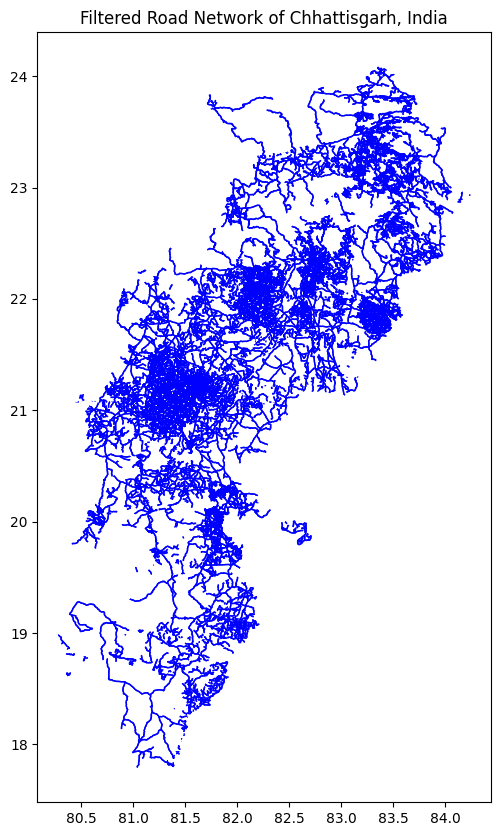

In [9]:
# Filter road types
roads = edges[edges['highway'].isin(['residential', 'unclassified', 'primary', 'secondary', 'tertiary'])]

# Plot the filtered road network
fig, ax = plt.subplots(figsize=(10, 10))
roads.plot(ax=ax, linewidth=1, edgecolor='blue')
plt.title(f"Filtered Road Network of {place_name}")
plt.show()

In [10]:
# Display basic information about the road network data (edges)
print("Road Network Data Info:")
print(edges.info())  # Gives the column names, data types, and non-null counts

# Show the number of rows and columns
print(f"Number of rows and columns: {edges.shape}")

# Show the summary statistics of numerical columns
print("Summary statistics of numerical columns:")
print(edges.describe())

# For categorical columns, show value counts (e.g., road types)
print("Value counts for road types (highway column):")
print(edges['highway'].value_counts())


Road Network Data Info:
<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 533344 entries, (2130346973, 9966289775, 0) to (10727166591, 6377320577, 0)
Data columns (total 16 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   osmid     533344 non-null  object  
 1   highway   533344 non-null  object  
 2   oneway    533344 non-null  bool    
 3   reversed  533344 non-null  object  
 4   length    533344 non-null  float64 
 5   geometry  533344 non-null  geometry
 6   lanes     5777 non-null    object  
 7   ref       11622 non-null   object  
 8   name      7498 non-null    object  
 9   bridge    12180 non-null   object  
 10  maxspeed  2781 non-null    object  
 11  tunnel    428 non-null     object  
 12  junction  590 non-null     object  
 13  access    3719 non-null    object  
 14  service   284 non-null     object  
 15  width     350 non-null     object  
dtypes: bool(1), float64(1), geometry(1), object(13)
memory usage: 85.5

Number of Dead-End Nodes: 21


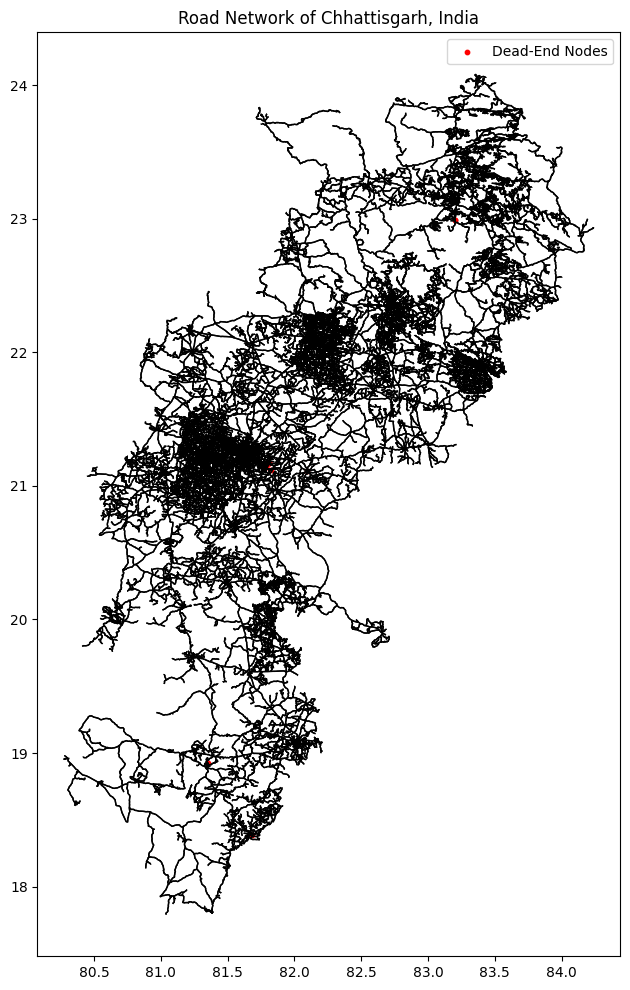

In [12]:
dead_end_nodes = [node for node, degree in dict(G.degree()).items() if degree == 1]
isolated_nodes = [node for node in G.nodes() if G.degree(node) == 0]

# Convert lists to GeoDataFrames
dead_end_nodes_gdf = nodes.loc[nodes.index.isin(dead_end_nodes)]
isolated_nodes_gdf = nodes.loc[nodes.index.isin(isolated_nodes)]

# Plot the road network
fig, ax = plt.subplots(figsize=(12, 12))
edges.plot(ax=ax, linewidth=1, edgecolor='black')

if not dead_end_nodes_gdf.empty:
    dead_end_nodes_gdf.plot(ax=ax, color='red', markersize=10, label='Dead-End Nodes', linestyle='None')

# set aspect ratio
ax.set_aspect('equal')

print(f"Number of Dead-End Nodes: {len(dead_end_nodes)}")

plt.title(f"Road Network of {place_name}")
plt.legend()
plt.show()

/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


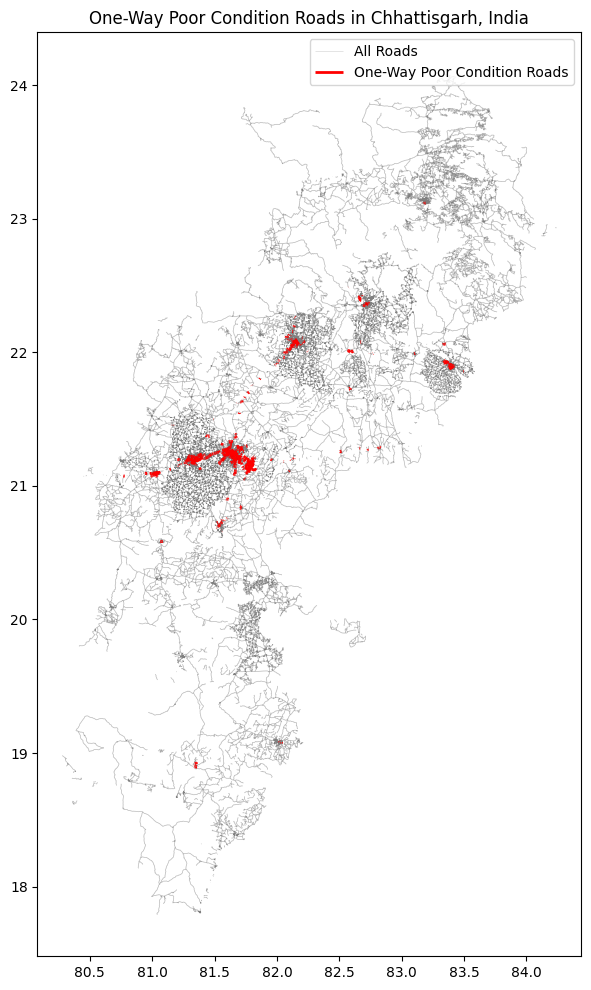

Number of One-Way Poor Condition Roads: 4080


In [16]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Placeholder function to simulate road condition analysis
def detect_road_conditions(roads):
    # Assign a random "condition" status to each road for now
    roads['condition'] = ['good' if i % 2 == 0 else 'poor' for i in range(len(roads))]
    return roads

# Analyze road conditions
roads = detect_road_conditions(roads)

# Filter for one-way and poor condition roads
oneway_poor_condition_roads = roads[(roads['oneway'] == True) & (roads['condition'] == 'poor')]

# Plot the roads with conditions
fig, ax = plt.subplots(figsize=(12, 12))
# Optionally, plot all roads for context
roads.plot(ax=ax, color='grey', linewidth=0.5, label='All Roads', alpha=0.3)

# Highlight one-way poor condition roads in red
oneway_poor_condition_roads.plot(ax=ax, color='red', linewidth=2, label='One-Way Poor Condition Roads')

plt.legend()
plt.title(f"One-Way Poor Condition Roads in {place_name}")
plt.show()

# Print the number of one-way poor condition roads
print(f"Number of One-Way Poor Condition Roads: {len(oneway_poor_condition_roads)}")

In [17]:
# Extract 'u' and 'v' values (start and end nodes) from the geometry
oneway_poor_condition_roads['u'] = oneway_poor_condition_roads['geometry'].apply(lambda geom: geom.coords[0])  # start point
oneway_poor_condition_roads['v'] = oneway_poor_condition_roads['geometry'].apply(lambda geom: geom.coords[-1])  # end point

# Print the extracted 'u' and 'v' values for each road segment
for idx, row in oneway_poor_condition_roads.iterrows():
    print(f"Road Segment {idx}: Start (u) = {row['u']}, End (v) = {row['v']}")


/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Road Segment (7997401765, 7997401785, 0): Start (u) = (81.0745904, 20.5828064), End (v) = (81.0747251, 20.5829046)
Road Segment (7997401785, 7997401786, 0): Start (u) = (81.0747251, 20.5829046), End (v) = (81.0748248, 20.582799)
Road Segment (7997401786, 7997401787, 0): Start (u) = (81.0748248, 20.582799), End (v) = (81.0747141, 20.5826886)
Road Segment (7997401787, 7997401765, 0): Start (u) = (81.0747141, 20.5826886), End (v) = (81.0745904, 20.5828064)
Road Segment (1669149867, 12048790370, 0): Start (u) = (81.0398893, 21.0910517), End (v) = (81.0395573, 21.0905798)
Road Segment (1682314928, 2483558052, 0): Start (u) = (81.019265, 21.0958321), End (v) = (81.0184864, 21.0957805)
Road Segment (2267375666, 5576872035, 0): Start (u) = (80.7774274, 21.0735391), End (v) = (80.7725316, 21.0733506)
Road Segment (2483557946, 4561861957, 0): Start (u) = (80.9939873, 21.0940677), End (v) = (80.9794076, 21.0928417)
Road Segment (2483557954, 4561862017, 0): Start (u) = (80.9939911, 21.0941733), En

In [18]:
# Initialize a counter to track the number of alternative paths found
alternative_paths_count = 0
no_path_segments = 0
node_not_found_segments = 0

for idx, row in oneway_poor_condition_roads.iterrows():
    u, v = row['u'], row['v']

    print(f"Analyzing alternative path for road segment: ({u}, {v})")

    # Check if both nodes exist in the graph before proceeding
    if not G.has_node(u) or not G.has_node(v):
        print(f"Node(s) not found in graph for segment: ({u}, {v})")
        node_not_found_segments += 1
        continue  # Skip to the next iteration

    # Remove the poor-quality road segment from the graph
    if G.has_edge(u, v):
        G.remove_edge(u, v)

    # Try to find an alternative path between 'u' and 'v'
    try:
        # Use Dijkstra's algorithm to find the shortest path, excluding the removed edge
        alternative_path = nx.shortest_path(G, source=u, target=v, weight='weight')
        print(f"Alternative path found: {alternative_path}")
        alternative_paths_count += 1
    except nx.NetworkXNoPath:
        print(f"No alternative path found for segment: ({u}, {v})")
        no_path_segments += 1

    # Optionally, you could add back the removed edge for the next iteration
    G.add_edge(u, v, weight=row['geometry'].length)

# Summary of results
print(f"Number of alternative paths found: {alternative_paths_count}")
print(f"Number of segments with no alternative path: {no_path_segments}")
print(f"Number of segments with NodeNotFound errors: {node_not_found_segments}")

Analyzing alternative path for road segment: ((81.0745904, 20.5828064), (81.0747251, 20.5829046))
Node(s) not found in graph for segment: ((81.0745904, 20.5828064), (81.0747251, 20.5829046))
Analyzing alternative path for road segment: ((81.0747251, 20.5829046), (81.0748248, 20.582799))
Node(s) not found in graph for segment: ((81.0747251, 20.5829046), (81.0748248, 20.582799))
Analyzing alternative path for road segment: ((81.0748248, 20.582799), (81.0747141, 20.5826886))
Node(s) not found in graph for segment: ((81.0748248, 20.582799), (81.0747141, 20.5826886))
Analyzing alternative path for road segment: ((81.0747141, 20.5826886), (81.0745904, 20.5828064))
Node(s) not found in graph for segment: ((81.0747141, 20.5826886), (81.0745904, 20.5828064))
Analyzing alternative path for road segment: ((81.0398893, 21.0910517), (81.0395573, 21.0905798))
Node(s) not found in graph for segment: ((81.0398893, 21.0910517), (81.0395573, 21.0905798))
Analyzing alternative path for road segment: ((81